## Telco Churning Project using Machine Learning

This project will utilize the CRISP-DM framework for its analysis

## Business Understanding



Using the provided dataset, a business could gain insights into the factors that influence customer churn. For example, analyzing customer demographics (e.g., gender, SeniorCitizen status) could reveal if certain groups are more likely to churn, allowing the company to tailor retention efforts to those groups. Understanding the impact of services (e.g., PhoneService, InternetService) on churn could help in improving service quality or offering promotions to retain customers.

Furthermore, analyzing contract terms (e.g., Contract length, PaperlessBilling) and payment methods could provide insights into the effectiveness of different billing strategies in retaining customers. By identifying these factors and their impact on churn, businesses can develop targeted retention strategies, such as personalized offers, loyalty programs, or improved customer service, to reduce churn and increase customer loyalty.

Null Hypothesis 
- There is no significant relationship between the contract terms and customer churn.

Alternate Hypothesis
- There is a significant relationship between the contract terms and customer churn.

Analytical Questions
1. What is the total churn rate

2. What is the churn rate by gender?

3. How does the citizen level affect their likelihood to churn?

4. Are customers with PhoneService more likely to churn?

5. How do contract terms (e.g., Contract length, PaperlessBilling) influence churn?

6. What role do payment methods play in customer churn?

Data Extraction

In [110]:
## importing the necessary libraries
#%pip install pyodbc python-dotenv 

import pyodbc    
from dotenv import dotenv_values
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
import seaborn as sns
from scipy.stats import chi2_contingency
import missingno as msno
import sklearn
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline as Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import joblib
warnings.filterwarnings('ignore')

In [14]:


connection_string = f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'
# Connect to the database
try:
    conn = pyodbc.connect(connection_string)
    cursor = conn.cursor()
    print('Connection established successfully.')
except Exception as e:
    print(f'Error connecting to the database: {e}')


Connection established successfully.


In [15]:
## loading of the first 3000 rows of dataset
query = "Select * from dbo.LP2_Telco_churn_first_3000"

data3000 = pd.read_sql(query, conn)
data3000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [16]:
## saving the first 3000 as csv
data3000.to_csv("churnfirst3000.csv", index=False)

In [20]:
## checking the second 2000rows of the dataset
data2000 = pd.read_csv('LP2_Telco-churn-second-2000.csv')
data2000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


Data Understanding

In [21]:
## Merging both datasets before analyzing
df = pd.concat([data3000, data2000], axis=0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [22]:
##check the tail
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
2039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
2040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
2041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
2042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [23]:
## checking the number of entries in the entire dataset and the datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [24]:
##checking for null valuess
df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [25]:
## checking for duplicates
df.duplicated().value_counts()

False    5043
Name: count, dtype: int64

In [26]:
## checking uniques 
df.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                4
Dependents             4
tenure                73
PhoneService           4
MultipleLines          5
InternetService        3
OnlineSecurity         5
OnlineBackup           5
DeviceProtection       5
TechSupport            5
StreamingTV            5
StreamingMovies        5
Contract               3
PaperlessBilling       4
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4884
Churn                  4
dtype: int64

In [27]:
## decriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


Observations
- We can see from the mean and medians that our data is not normally distributed since the mean and median arent really close
- On the average, Total Charges is around 2,302
- On the average, Monthly charges is around 65

In [28]:
## checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [29]:
# Checking unique entries in each column
for column in df.columns:
    unique_entries = df[column].unique()
    print(f"Column '{column}' has {len(unique_entries)} unique entries:")
    print(unique_entries[:])
    print()

Column 'customerID' has 5043 unique entries:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Column 'gender' has 2 unique entries:
['Female' 'Male']

Column 'SeniorCitizen' has 2 unique entries:
[0 1]

Column 'Partner' has 4 unique entries:
[True False 'No' 'Yes']

Column 'Dependents' has 4 unique entries:
[False True 'No' 'Yes']

Column 'tenure' has 73 unique entries:
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Column 'PhoneService' has 4 unique entries:
[False True 'Yes' 'No']

Column 'MultipleLines' has 6 unique entries:
[None False True 'No' 'No phone service' 'Yes']

Column 'InternetService' has 3 unique entries:
['DSL' 'Fiber optic' 'No']

Column 'OnlineSecurity' has 6 unique entries:
[False True None 'No' 'Yes' 'No internet service']

Column 'OnlineBackup' has 6 u

In [30]:
def map_to_boolean(df):
    df["Partner"] = df["Partner"].map({True: "Yes", False: "No", "Yes": "Yes", "No": "No"})
    df["PhoneService"] = df["PhoneService"].map({True: "Yes", False: "No", "Yes": "Yes", "No": "No"})
    df["Dependents"] = df["Dependents"].map({True: "Yes", False: "No","Yes": "Yes", "No": "No"})
    df["MultipleLines"] = df["MultipleLines"].map({True: "Yes", False: "No","Yes": "Yes", "No": "No","No phone service": "No phone service"})
    df["InternetService"] = df["InternetService"].map({"No": "No", "DSL": "DSL", "Fiber optic": "Fiber optic"})
    df["OnlineSecurity"] = df["OnlineSecurity"].map({True: "Yes", False: "No", "Yes":"Yes", "No":"No", "No internet service": "No internet service"})
    df["OnlineBackup"] = df["OnlineBackup"].map({True: "Yes", False: "No", "Yes":"Yes", "No":"No","No internet service": "No internet service"})
    df["DeviceProtection"] = df["DeviceProtection"].map({True: "Yes", False: "No", "Yes":"Yes", "No":"No", "No internet service": "No internet service"})
    df["TechSupport"] = df["TechSupport"].map({True: "Yes", False: "No", "Yes":"Yes", "No":"No", "No internet service": "No internet service"})
    df["StreamingTV"] = df["StreamingTV"].map({True: "Yes", False: "No", "Yes":"Yes", "No":"No", "No internet service": "No internet service"})
    df["StreamingMovies"] = df["StreamingMovies"].map({True: "Yes", False: "No", "Yes":"Yes", "No":"No", "No internet service": "No internet service"})
    df["PaperlessBilling"] = df["PaperlessBilling"].map({True: "Yes", False: "No", "Yes":"Yes", "No":"No"})
    df["Churn"] = df["Churn"].map({True: "Yes", False: "No", "Yes":"Yes", "No":"No"})

    return df

# Example usage
df = map_to_boolean(df)

In [31]:
df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [32]:
## checking unique entries in each column
for column in df.columns:
    unique_entries = df[column].unique()
    print(f"Column '{column}' has {len(unique_entries)} unique entries:")
    print(unique_entries[:])
    print()

Column 'customerID' has 5043 unique entries:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Column 'gender' has 2 unique entries:
['Female' 'Male']

Column 'SeniorCitizen' has 2 unique entries:
[0 1]

Column 'Partner' has 2 unique entries:
['Yes' 'No']

Column 'Dependents' has 2 unique entries:
['No' 'Yes']

Column 'tenure' has 73 unique entries:
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Column 'PhoneService' has 2 unique entries:
['No' 'Yes']

Column 'MultipleLines' has 4 unique entries:
[nan 'No' 'Yes' 'No phone service']

Column 'InternetService' has 3 unique entries:
['DSL' 'Fiber optic' 'No']

Column 'OnlineSecurity' has 4 unique entries:
['No' 'Yes' nan 'No internet service']

Column 'OnlineBackup' has 4 unique entries:
['Yes' 'No' nan 'No internet service']

Co

In [33]:
for col in df.columns:
    df_ = df[col].value_counts()
    print(f"Value counts for column '{col}':\n{df_}\n")


Value counts for column 'customerID':
customerID
7590-VHVEG    1
5143-EGQFK    1
8232-CTLKO    1
0847-HGRML    1
9050-QLROH    1
             ..
5451-MHQOF    1
0999-QXNSA    1
1060-ENTOF    1
3283-WCWXT    1
3186-AJIEK    1
Name: count, Length: 5043, dtype: int64

Value counts for column 'gender':
gender
Male      2559
Female    2484
Name: count, dtype: int64

Value counts for column 'SeniorCitizen':
SeniorCitizen
0    4224
1     819
Name: count, dtype: int64

Value counts for column 'Partner':
Partner
No     2585
Yes    2458
Name: count, dtype: int64

Value counts for column 'Dependents':
Dependents
No     3482
Yes    1561
Name: count, dtype: int64

Value counts for column 'tenure':
tenure
1     434
72    257
2     167
3     144
71    124
     ... 
39     40
28     39
44     36
36     34
0       8
Name: count, Length: 73, dtype: int64

Value counts for column 'PhoneService':
PhoneService
Yes    4554
No      489
Name: count, dtype: int64

Value counts for column 'MultipleLines':
Multi

Exploratory Data Analysis on numeric columns


In [34]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert to numeric with errors set to 'coerce'


In [35]:
df.columns.unique()

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

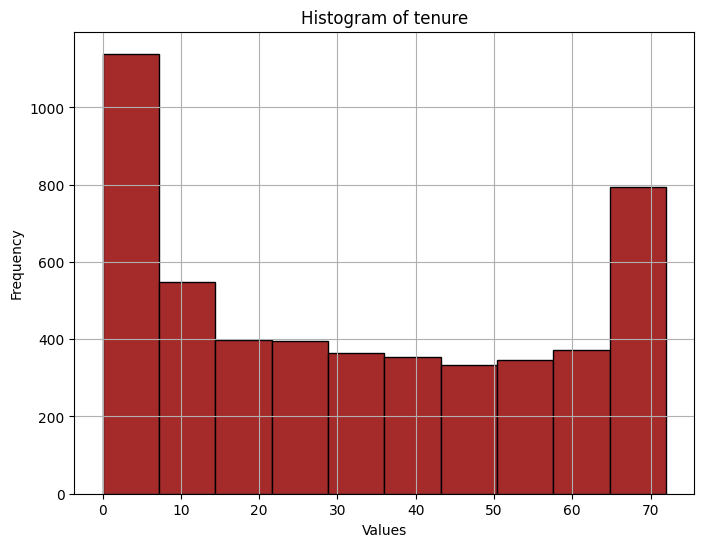

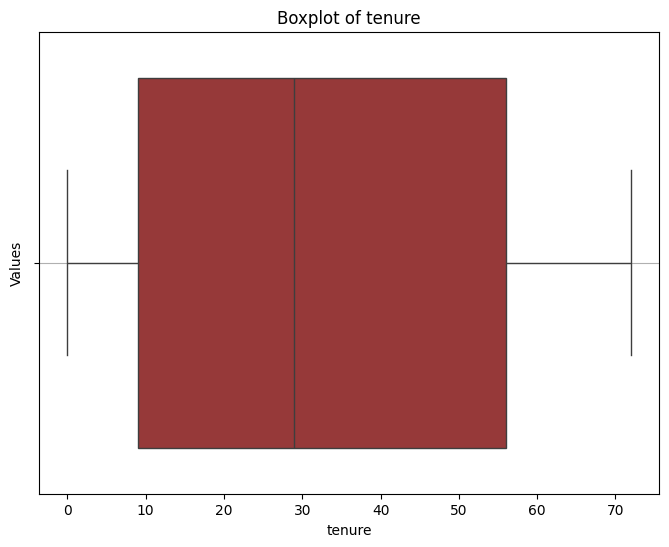

In [36]:
# Create a histogram for tenure
plt.figure(figsize=(8, 6))
plt.hist(df['tenure'], bins=10, color='brown', edgecolor='black')
plt.title('Histogram of tenure')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Create a boxplot for tenure
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['tenure'], color='brown', orient='v')
plt.title('Boxplot of tenure')
plt.ylabel('Values')
plt.grid(True, axis='y')
plt.show()


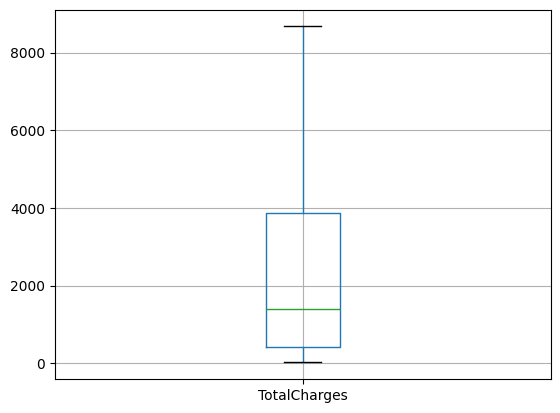

In [37]:
## checking the distribution in the Total charges
df.boxplot(column='TotalCharges')
plt.show()

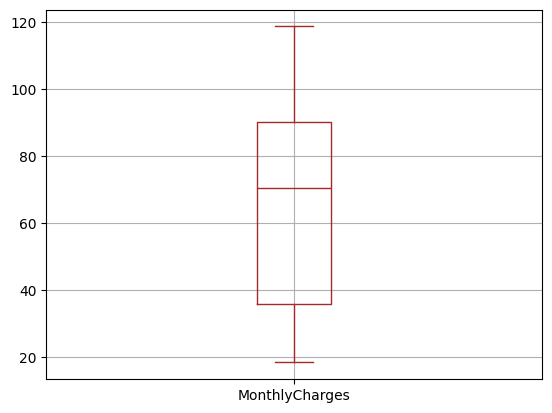

In [38]:
## visualizing the distribution of monthly charges
df.boxplot(column='MonthlyCharges', color='brown')
plt.show()

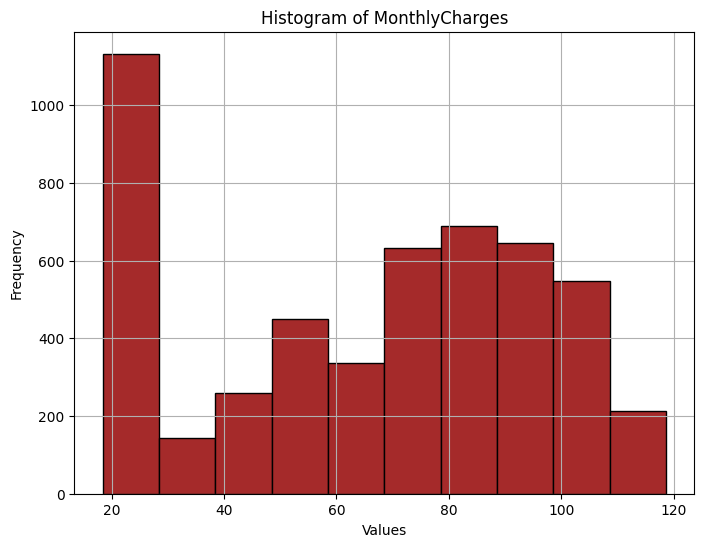

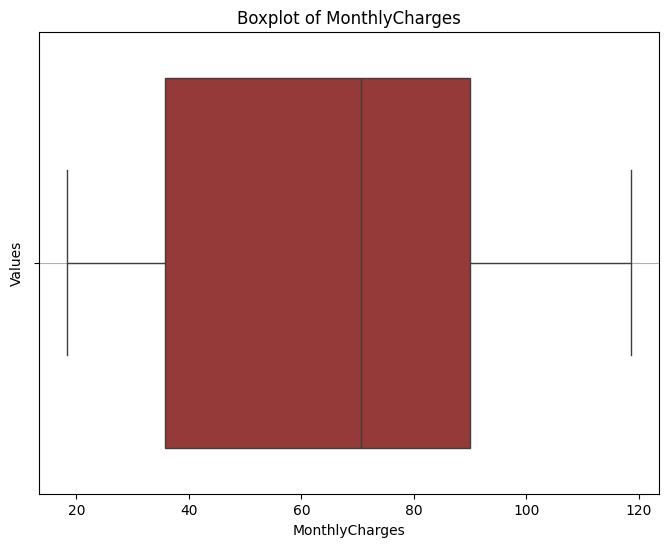

In [39]:
# Create a histogram for MonthlyCharges
plt.figure(figsize=(8, 6))
plt.hist(df['MonthlyCharges'], bins=10, color='brown', edgecolor='black')
plt.title('Histogram of MonthlyCharges')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Create a boxplot for MonthlyCharges
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['MonthlyCharges'], color='brown', orient='v')
plt.title('Boxplot of MonthlyCharges')
plt.ylabel('Values')
plt.grid(True, axis='y')
plt.show()

##### Exploratory Data Analysis On Some Categorical features

In [40]:
## Creating numeric columns and categorical columns
numeric_cols = df.select_dtypes(include=["int","float"])
categorical_cols = df.select_dtypes(include=["object"])


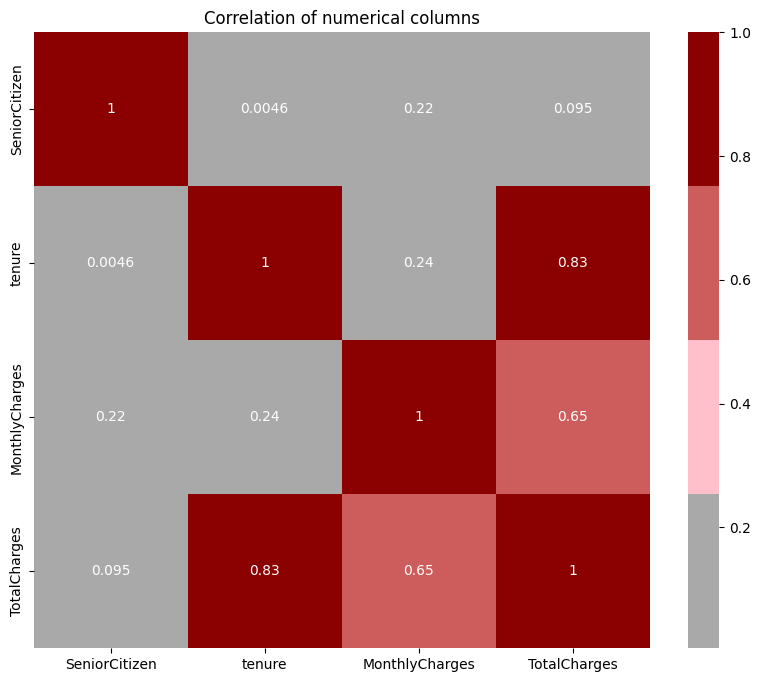

In [41]:
## checking correlation between the numerics
corr_matrix = numeric_cols.corr()
colors = ["#A9A9A9","#FFC0CB", "#CD5C5C","#8B0000"]
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=colors, square=True)
plt.title("Correlation of numerical columns")
plt.show()

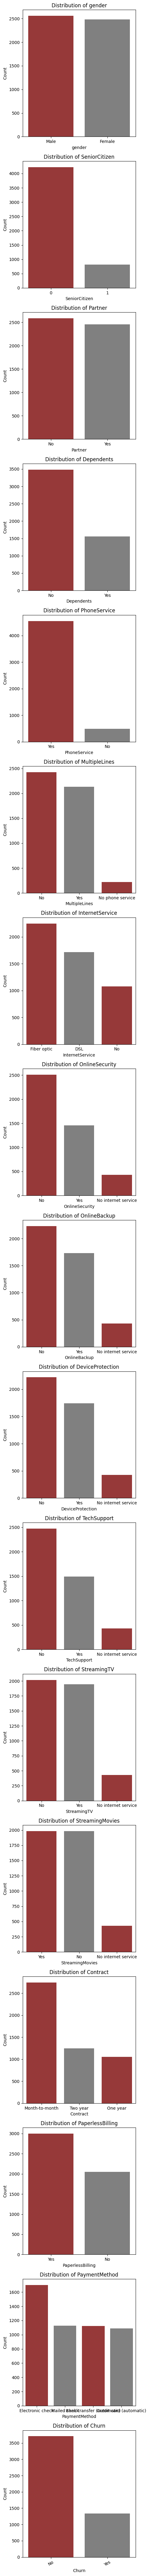

In [42]:

## Plotting the distributions in categorical columns
def plot_subplots(df, columns):
    num_cols = len(columns)
    fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(5, 5*num_cols))
    
    for i, col in enumerate(columns):
        counts = df[col].value_counts()
        sns.barplot(x=counts.index, y=counts.values, ax=axes[i],palette={"grey","Brown"})
        plt.xticks(rotation=30)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

# Example usage
columns_to_plot = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines" , "InternetService", "OnlineSecurity", "OnlineBackup", 
                   "DeviceProtection", "TechSupport", "StreamingTV", 
                   "StreamingMovies", "Contract", "PaperlessBilling", 
                   "PaymentMethod", "Churn"]
plot_subplots(df, columns_to_plot)



1. What is the total churn rate?

<Axes: ylabel='count'>

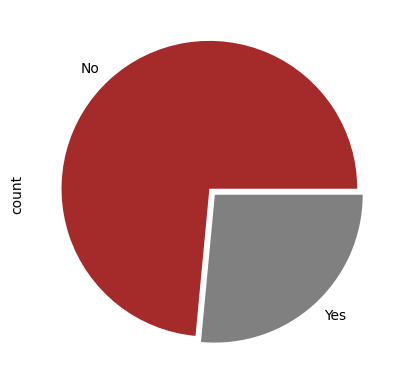

In [43]:
df["Churn"].value_counts().plot.pie(explode=(0.05,0.005), colors=['brown', "grey"])

2. What is the churn rate among different demographic groups (e.g., gender, SeniorCitizen status)?

In [44]:
df.groupby("gender")["Churn"].value_counts()

gender  Churn
Female  No       1823
        Yes       661
Male    No       1883
        Yes       675
Name: count, dtype: int64

<Axes: xlabel='gender', ylabel='count'>

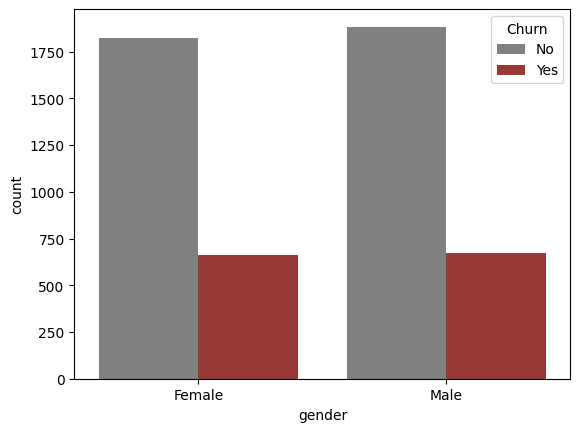

In [45]:
sns.countplot(data=df, x="gender", hue="Churn", palette={"No":"grey", "Yes":"Brown"})

3. How does the citizen level affect their likelihood to churn?

<Axes: xlabel='SeniorCitizen', ylabel='count'>

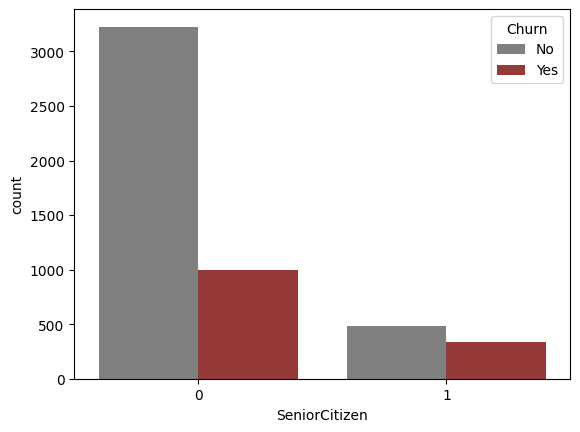

In [46]:
sns.countplot(data=df, x="SeniorCitizen", hue="Churn",palette={"No":"grey", "Yes":"Brown"})

4. Are customers with Phone Services more likely to churn?

<Axes: xlabel='PhoneService', ylabel='count'>

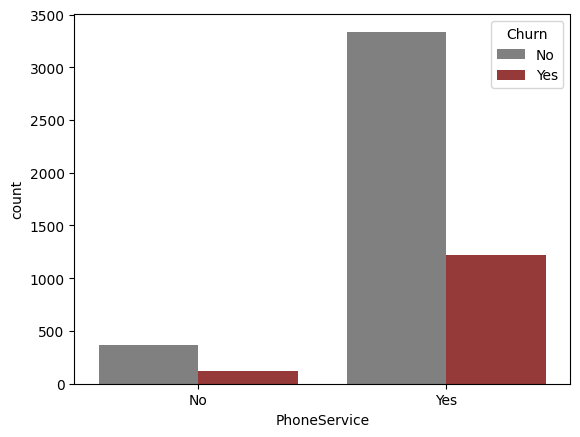

In [47]:
sns.countplot(data=df, x="PhoneService", hue="Churn",palette={"No":"grey", "Yes":"Brown"})

5. How do contract terms (e.g., Contract length, PaperlessBilling) influence churn?

<Axes: xlabel='Contract', ylabel='count'>

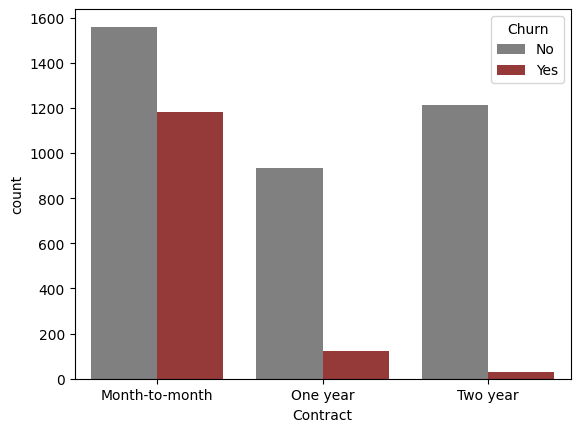

In [48]:
sns.countplot(data=df, x="Contract", hue="Churn",palette={"No":"grey", "Yes":"Brown"})

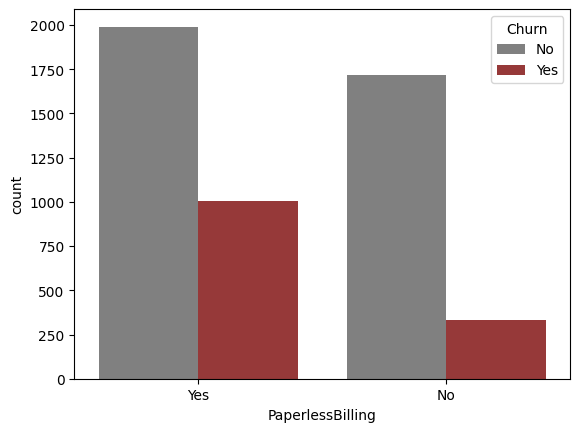

In [49]:
sns.countplot(data=df, x="PaperlessBilling", hue="Churn",palette={"No":"grey", "Yes":"Brown"})
plt.show()

6. What role do payment methods play in customer churn?

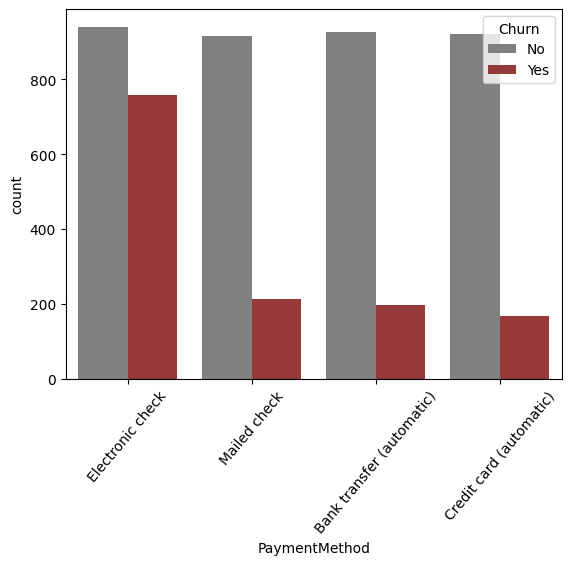

In [50]:
sns.countplot(data=df, x="PaymentMethod", hue="Churn",palette={"No":"grey", "Yes":"Brown"})
plt.xticks(rotation=50)
plt.show()

Insights from analytical questions
1. Customers with more contract terms have lesser churning rate (Probably long term contracts looks appealing as compared to short term)
2. Churning based on gender is almost the same
3. Customers having phone services churn more as compared to those who do not have phone services
4. Customers who have paperless billing churn more (Probably the company need to check their paperless biling systems)
5. Customers who pay their bills with electronic checks churn more 

In [51]:
df["TechSupport"].value_counts()

TechSupport
No                     2472
Yes                    1491
No internet service     429
Name: count, dtype: int64

## Hypothesis Testing

Chi square test will be used for hypothesis testing. The chi-square test helps you assess whether there is evidence to reject the null hypothesis that the two categorical variables are independent. If the p-value is low, you can conclude that there is a significant association between the variables. If the p-value is high, you fail to reject the null hypothesis, suggesting that there is no significant association.

In [52]:


# Creating a contigency table
contingency_table = pd.crosstab(df['Contract'], df['Churn'])

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# printing results of the p-value
print("P-value:", p)

# printing Results of the t-test
# having alpha to be 0.05(level of significance)
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis - There is a significant relationship between Contract terms and Churn.")
else:
    print("Fail to reject the null hypothesis - There is no significant relationship between Contract terms and Churn.")



P-value: 3.61789584641233e-192
Reject the null hypothesis - There is a significant relationship between Contract terms and Churn.


Observation
- We can see from the results that our p-value is wayy lesser than the significance level. Hence we can conclude that the null     hypothesis we have is less significant and hence we have enough confidence to reject the null hypothesis.
- This means our alternative hypothesis is actually true (There is a relationship between Contracts and Churn)

## Data Preperation

#### Checking if the dataset is balanced

In [53]:
# checking distribution of the Churn column
df["Churn"].value_counts()

Churn
No     3706
Yes    1336
Name: count, dtype: int64

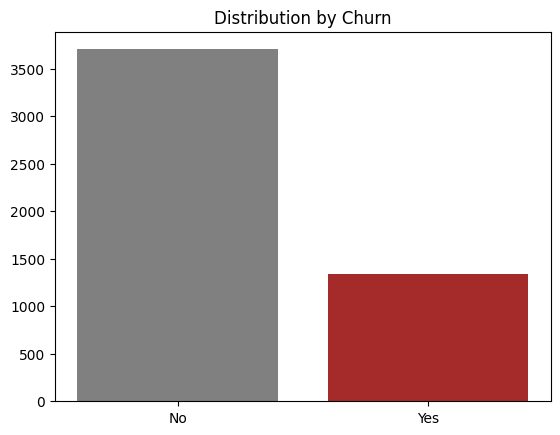

In [54]:
## checking if data is balanced
colors = ['brown' if x == 'Yes' else 'grey' for x in df['Churn'].value_counts().index]
plt.bar(df['Churn'].value_counts().index, df['Churn'].value_counts(), color=colors)
plt.title("Distribution by Churn")
plt.show()

Observation
- From the visualization above, we can see that the target is not balanced. 

Solutions
- Using models that can handle imbalanced datasets eg: RandomForests, XGBoost, Catboost, Adaboost, LogisticRegressor
- Instead of using accuracy, which can be misleading for imbalanced datasets, we will consider using metrics like precision, recall, F1-score
- Collecting more data for the minority class which is Churned customers("yes") 

In [55]:
## Dropping the missing rows in Churn
df.dropna(subset=["Churn"], inplace=True)

In [56]:
## checking if the values have been dropped
df["Churn"].isna().sum()

0

In [57]:
## dropping customerID
df = df.drop(columns=["customerID"])

In [58]:
df["tenure"].value_counts()

tenure
1     434
72    256
2     167
3     144
71    124
     ... 
39     40
28     39
44     36
36     34
0       8
Name: count, Length: 73, dtype: int64

In [59]:
df["Contract"].value_counts()

Contract
Month-to-month    2744
Two year          1243
One year          1055
Name: count, dtype: int64

In [60]:
## Encoding the label 
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

In [61]:
df.isna().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

In [62]:
numeric_cols.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.850000,29.850000
1,0,34,56.950001,1889.500000
2,0,2,53.849998,108.150002
3,0,45,42.299999,1840.750000
4,0,2,70.699997,151.649994


In [63]:
categorical_cols.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,Female,Yes,No,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,No,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [64]:
## Creating numeric columns and categorical columns
numeric_cols = ["MonthlyCharges", "TotalCharges", "tenure"]
categorical_cols = ["gender", "SeniorCitizen", "Contract", "PaymentMethod", "PaperlessBilling", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity"]


In [65]:
categorical_cols

['gender',
 'SeniorCitizen',
 'Contract',
 'PaymentMethod',
 'PaperlessBilling',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity']

In [66]:

numeric_cols

['MonthlyCharges', 'TotalCharges', 'tenure']

In [67]:
## Splitting dataset into features and target values
X = df.drop(columns=["Churn"], axis=1)
y = df["Churn"]

In [68]:
#X_resamp, y_resamp = smote.fit_resample(X_train, y_train)

In [69]:
## Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
## Label Encoding
Label_enc = LabelEncoder()
y_train_encoded = Label_enc.fit_transform(y_train)

## we use only tranform since the yes or no has already been learn in fittranform
y_test_encoded = Label_enc.transform(y_test)


##### Optimization using GridsearchCV

In [72]:
## creating pipeline for Preprocessing of categorical and numeric columns 
numerical_pipeline = Pipeline(steps=[ 
    ("num_imputer", SimpleImputer(strategy="median")), 
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("cat_imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder()),
    
])

preprocessor = ColumnTransformer(transformers=[
    ("num_pipeline", numerical_pipeline, numeric_cols),
    ("cat_pipeline",categorical_pipeline, categorical_cols)
])

In [73]:
best_params_dict = {}
# Create pipelines for each model
pipelines = [
    ("XGBClassifier", Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=42))
    ])),
    ("Logistic Regression", Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42))
    ])),
    ("Decision Tree", Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42))
    ])),
    ("Random Forest", Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42))
    ]))
]

# Define hyperparameter grids for each model
param_grids = {
    "XGBClassifier": {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.3]
    },
    "Logistic Regression": {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.1, 1, 10]
    },
    "Decision Tree": {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 5, 10, 20]
    },
    "Random Forest": {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10, 20]
    }
}

# Perform GridSearchCV for each model
for model_name, pipeline in pipelines:
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train_encoded)
    best_params_dict[model_name] = grid_search.best_params_
##best params for each model    
best_params_dict


{'XGBClassifier': {'classifier__learning_rate': 0.1,
  'classifier__max_depth': 3,
  'classifier__n_estimators': 100},
 'Logistic Regression': {'classifier__C': 1, 'classifier__penalty': 'l2'},
 'Decision Tree': {'classifier__criterion': 'gini',
  'classifier__max_depth': 5},
 'Random Forest': {'classifier__max_depth': 5,
  'classifier__n_estimators': 200}}

Observation
- By using gridsearchcv, the best parametrs for the various models being used for this project for best performance has been obtained.

In [74]:
## creating pipeline for Preprocessing of categorical and numeric columns 
numerical_pipeline = Pipeline(steps=[ 
    ("num_imputer", SimpleImputer(strategy="median")), 
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("cat_imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder()),
    
])

preprocessor = ColumnTransformer(transformers=[
    ("num_pipeline", numerical_pipeline, numeric_cols),
    ("cat_pipeline",categorical_pipeline, categorical_cols)
])

In [75]:
models = [
    ("Logistic Regression", LogisticRegression(random_state=42, C=1, penalty='l2')),
    ("Decision Tree", DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=5)),
    ("Random Forest", RandomForestClassifier(random_state=42, max_depth=5, n_estimators=200)),
    ("XGBoost", XGBClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=100)),
]


In [76]:
all_pipeline={}
all_confusion_matrix={}

##creating dataframe to store all metrics
metric_table = pd.DataFrame(columns=["model", "precision", "recall", "f1-score"])

for model_name, classifier in models:

    final_pipeline = imbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", classifier)
    ])

    
    # fit data to pipeline
    final_pipeline.fit(X_train, y_train_encoded)

    #Add all pipelines into the all_balanced_pipeline dictionary
    all_pipeline[model_name] = final_pipeline
    
    #predicting on evaluation set
    y_pred = final_pipeline.predict(X_test)

    ##confusion matrix
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)

    ## Adding all confusion matrix into the all_confusion_matrix dictionary
    all_confusion_matrix[model_name] = conf_matrix

    ##generating classification report for each model or pipeline
    metrics = classification_report(y_test_encoded, y_pred, output_dict=True)

    ##getting all metrics
    accuracy = metrics["accuracy"]
    precision = metrics["weighted avg"]["precision"]
    recall = metrics["weighted avg"]["recall"]
    f1_score = metrics["weighted avg"]["f1-score"]
    

    print(f"{model_name} model is trained")
    
    ## add key metrics to the metrics table
    metric_table.loc[len(metric_table)] = [model_name, precision, recall, f1_score]

metric_table.sort_values(by="f1-score", ascending=False)

Logistic Regression model is trained
Decision Tree model is trained
Random Forest model is trained
XGBoost model is trained


,model,precision,recall,f1-score
2,Random Forest,0.807504,0.817641,0.809385
0,Logistic Regression,0.808028,0.810704,0.809255
3,XGBoost,0.806329,0.809713,0.807841
1,Decision Tree,0.798422,0.803766,0.800652


Observation
- We can see that after optimizing the hyperparameters for each model, we are able to get the best top two model
- Random Forest and Logistic Regressor seem to have the best performance


In [77]:
## checking the confusion matrix of the top two models (Random Forest and Logistic Regression)
conf_mat = all_confusion_matrix["Logistic Regression"]

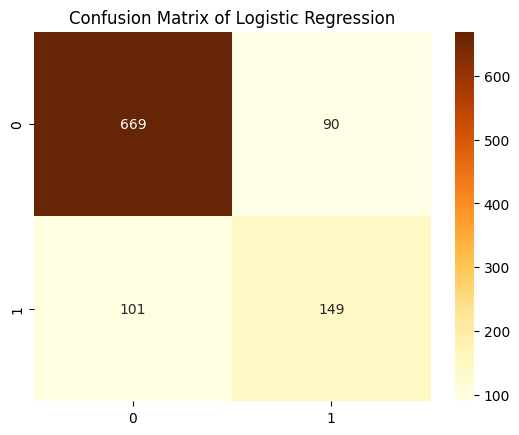

In [78]:
## Confusion matrix
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

In [79]:
## Confusion matrix of Random Forest
conf_mat_rf = all_confusion_matrix["Random Forest"]

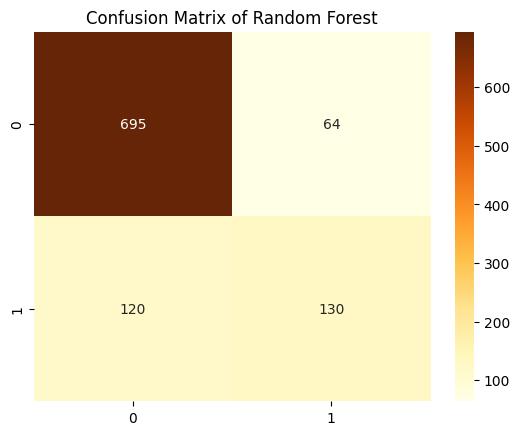

In [80]:
## Confusion matrix
sns.heatmap(conf_mat_rf, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix of Random Forest")
plt.show()

### Balancing the Dataset using smote 

In [82]:
all_balanced_pipeline={}
all_confusion_matrix={}

##creating dataframe to store all metrics
balanced_metric_table = pd.DataFrame(columns=["model", "precision", "recall", "f1-score"])

for model_name, classifier in models:

    final_balanced_pipeline = imbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote-sampler", SMOTE(random_state=42)),
    ("classifier", classifier)
    ])

    
    # fit data to pipeline
    final_balanced_pipeline.fit(X_train, y_train_encoded)

    #Add all pipelines into the all_balanced_pipeline dictionary
    all_balanced_pipeline[model_name] = final_balanced_pipeline
    
    #predicting on evaluation set
    y_pred = final_balanced_pipeline.predict(X_test)

    ##confusion matrix
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)

    ## Adding all confusion matrix into the all_confusion_matrix dictionary
    all_confusion_matrix[model_name] = conf_matrix


    ##generating classification report for each model or pipeline
    metrics = classification_report(y_test_encoded, y_pred, output_dict=True)

    ##getting all metrics
    accuracy = metrics["accuracy"]
    precision = metrics["weighted avg"]["precision"]
    recall = metrics["weighted avg"]["recall"]
    f1_score = metrics["weighted avg"]["f1-score"]
    
    print(f"{model_name} model is trained")
    
    ## add key metrics to the metrics table
    balanced_metric_table.loc[len(balanced_metric_table)] = [model_name, precision, recall, f1_score]

balanced_metric_table.sort_values(by="f1-score", ascending=False)

Logistic Regression model is trained
Decision Tree model is trained
Random Forest model is trained
XGBoost model is trained


,model,precision,recall,f1-score
3,XGBoost,0.810720,0.762141,0.775195
2,Random Forest,0.824005,0.755203,0.770571
0,Logistic Regression,0.812273,0.730426,0.748093
1,Decision Tree,0.809034,0.704658,0.724751


Observations after balancing the dataset using smote
- XGBoost seems to have the best performance after balancing the data followed by Random Forest and Logistic Regression.
- Lets analyze the confusion metrics to see if the XGBoost is indeed performing better per the objective of our project
- Objective(We are trying to build a model that will predict Churn of customers)
- It is good to note that our main focus in this project is to obtain as much True Positives as possible since we want to retain as many customers as possible. If the company is able to accurately predict most customers likely to churn, then special packages can be provided to those customers to retain them.

In [83]:
conf_mat_balanced_LR = all_confusion_matrix["Logistic Regression"]

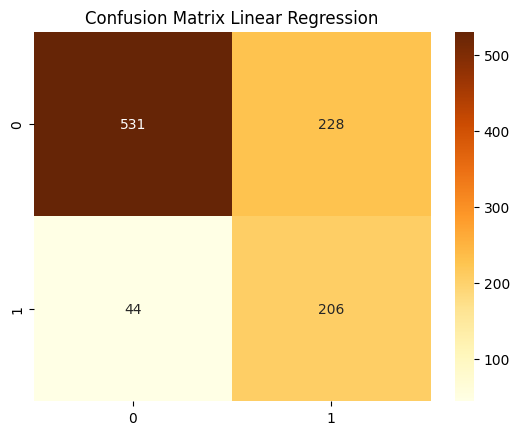

In [84]:
## Confusion matrix
sns.heatmap(conf_mat_balanced_LR, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix Linear Regression")
plt.show()

In [85]:
conf_mat_balanced_RF = all_confusion_matrix["Random Forest"]

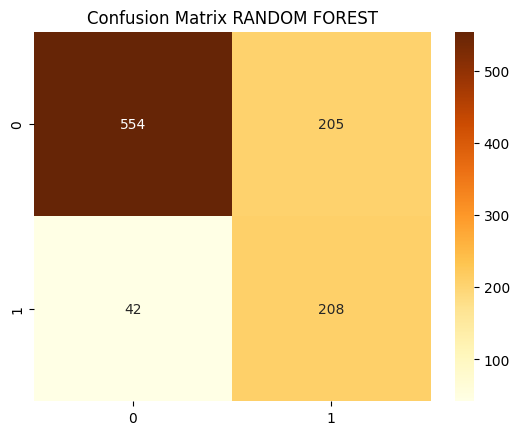

In [86]:
## Confusion matrix
sns.heatmap(conf_mat_balanced_RF, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix RANDOM FOREST")
plt.show()

In [87]:
conf_mat_balanced_XG = all_confusion_matrix["XGBoost"]

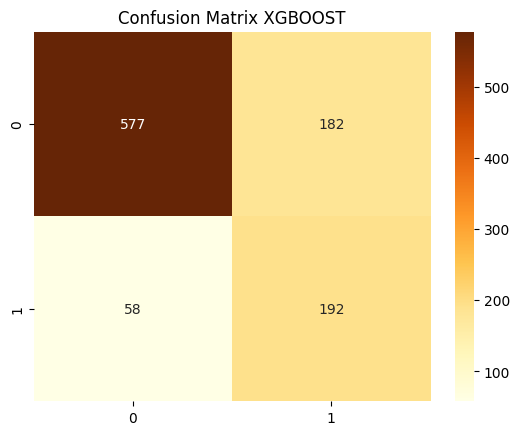

In [88]:
## Confusion matrix
sns.heatmap(conf_mat_balanced_XG, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix XGBOOST")
plt.show()

Observations from confusion matrix
- From the observations from the confusion metrics of the top three models, we can see that though XGBost  had a high precision, recall and f1-score, it is not able to predict most of the customers who will churn. 
- we can see that random forest and logistic regression are able to predict most of the customers who will churn. Both having 208 and 206 TRUE POSITIVES respectively unlike XGBoost with only 192 correct TRUE POSITIVES.

Key Insights to note
- Using the unbalanced data seeem to have a better performance in terms of precision, f1, and recall scores than balancing the data using SMOTE to balance the dataset for training.
- This observation is quite misleading since we are trying to build a model that will predict Churn of customers(Hence, according to the objective of our project, the best performing model is the one which actually predicts the most customers who will churn(TRUE POSITIVES))
- We can see that by analyzing the confusion matrices of both the unbalanced and balanced data, the balanced data actually yields a better performance in terms of the models being able to predict more TRUE POSITIVES.
- Out of the three models, Random forest and Linear regression predicts more true positives on the balanced dataset as required.

# ROC

Using ROC curve to comoare the performance of the models

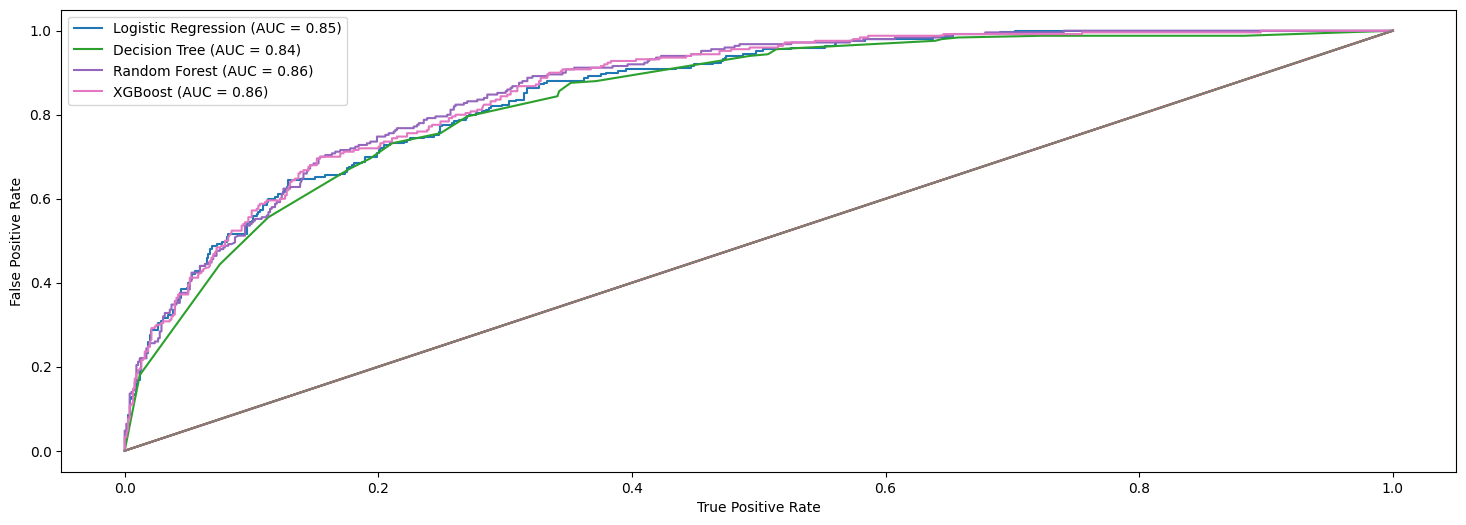

In [89]:
fig, ax = plt.subplots(figsize=(18, 6))

all_confusion_matrix = {}
all_roc_data = {}

for model_name, Pipeline in all_balanced_pipeline.items():

    y_score = Pipeline.predict_proba(X_test)[:, 1]  

    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_score)

    roc_auc = auc(fpr, tpr)

    roc_data_df = pd.DataFrame({"False Postive rate": fpr, "True Positive rate": tpr, "Threshold": thresholds})

    all_roc_data[model_name] = roc_data_df

    ax.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

    ax.plot([0,1], [0,1])
    ax.set_ylabel("False Positive Rate")
    ax.set_xlabel("True Positive Rate")
plt.legend()
plt.show()


In [90]:
all_roc_data["Logistic Regression"].tail(55)

,False Postive rate,True Positive rate,Threshold
201,0.375494,0.892,0.398802
202,0.375494,0.896,0.398512
203,0.379447,0.896,0.390708
204,0.379447,0.900,0.388297
205,0.388669,0.900,0.380066
206,0.388669,0.904,0.379913
207,0.395257,0.904,0.368816
208,0.395257,0.908,0.368472
209,0.434783,0.908,0.329631
210,0.434783,0.912,0.328988


Observations from ROC data
- Generally, we can see that there are variations in TP and FP rates for various thresholds.
- We want to select the threshold that gives a very high True Postive rate but at the same time a very low False Positive rate.
For logistic Regression, we can see that at a threshold of 0.291239.
True Positive Rate (TPR) = 0.936
False Positive Rate (FPR) = 0.474308
This is a good balance between TPR and FPR.

In [93]:
# Assinging a threshold to the model to predict the churn
threshold = 0.291239
y_pred_proba = all_balanced_pipeline["Logistic Regression"].predict_proba(X_test)[:,1]
binary_predictions = np.where(y_pred_proba > threshold, 1, 0)
threshold_matrix = confusion_matrix(y_test_encoded, binary_predictions)


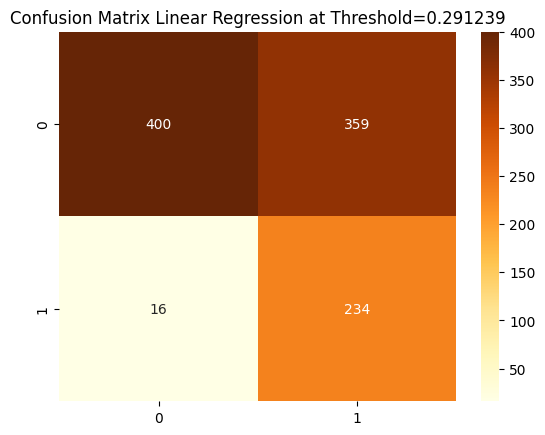

In [94]:

## Visualizing the improvement of our Linear Regression model to predict more True positives after changing the threshold to 0.291239
sns.heatmap(threshold_matrix, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix Linear Regression at Threshold=0.291239")
plt.show()

Observation
- We can see that after changing the threshold to 0.291239, we are able to predict more True Positives as indicated in the confusion matrix above. 
- True postive predictions in Linear regression has increased from 206 to 234

In [104]:
all_roc_data["Random Forest"].tail(55)

,False Postive rate,True Positive rate,Threshold
235,0.412385,0.924,0.381789
236,0.412385,0.928,0.381511
237,0.413702,0.928,0.378717
238,0.413702,0.932,0.378167
239,0.418972,0.932,0.375814
240,0.418972,0.936,0.375575
241,0.422925,0.936,0.374819
242,0.422925,0.940,0.373807
243,0.446640,0.940,0.352527
244,0.446640,0.944,0.351451


Random Forest ROC data Observation
- To find the threshold where the true positive rate (TPR) is very high and the false positive rate (FPR) is low, you'll need to look for a point where the TPR is close to 1 (indicating a high TPR) and the FPR is relatively low. Based on the roc data provided, the threshold that meets this criteria appears to be around 0.284758, where the TPR is 0.968 and the FPR is 0.525692.

In [101]:
# Assinging a threshold to the model to predict the churn
threshold = 0.284758
y_pred_proba_rf = all_balanced_pipeline["Random Forest"].predict_proba(X_test)[:,1]
binary_predictions = np.where(y_pred_proba_rf > threshold, 1, 0)
threshold_matrix = confusion_matrix(y_test_encoded, binary_predictions)

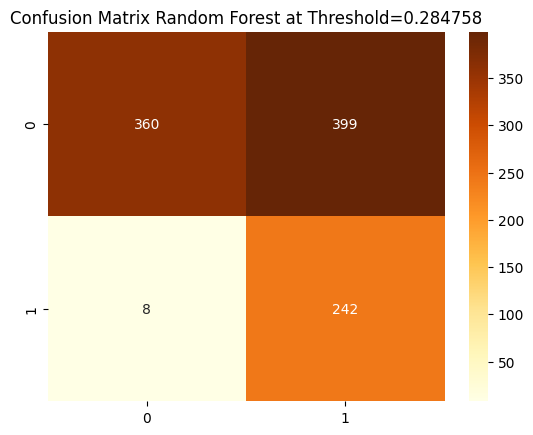

In [102]:
## Visualizing the improvement of our Random Forest model to predict more True positives after changing the threshold to 0.284758
sns.heatmap(threshold_matrix, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix Random Forest at Threshold=0.284758")
plt.show()

Observation
- To find the threshold where the true positive rate (TPR) is very high and the false positive rate (FPR) is low, you'll need to look for a point where the TPR is close to 1 (indicating a high TPR) and the FPR is relatively low. Based on the roc data provided, the threshold that meets this criteria appears to be around 0.284758, where the TPR is 0.968 and the FPR is 0.525692.

In [103]:
all_roc_data["XGBoost"].tail(55)

,False Postive rate,True Positive rate,Threshold
261,0.544137,0.976,0.149048
262,0.573123,0.976,0.134780
263,0.574440,0.980,0.134770
264,0.579710,0.980,0.129152
265,0.579710,0.984,0.128720
266,0.586298,0.984,0.125404
267,0.586298,0.988,0.123706
268,0.611331,0.988,0.102188
269,0.613966,0.988,0.100005
270,0.645586,0.988,0.080656


 XGBoost roc data observation
 - The threshold where the true positive rate (TPR) is very high and the false positive rate (FPR) is low appears to be around 
 0.024159. At this threshold, the TPR is 0.996 and the FPR is 0.776021. This indicates a high probability of correctly identifying positive cases (churn in this context) while minimizing the misclassification of negative cases as positive.

In [105]:
# Assinging a threshold to the XGBoost model to predict the churn(true positives)
threshold = 0.024159
y_pred_proba_XG = all_balanced_pipeline["XGBoost"].predict_proba(X_test)[:,1]
binary_predictions = np.where(y_pred_proba_XG > threshold, 1, 0)
threshold_matrix = confusion_matrix(y_test_encoded, binary_predictions)

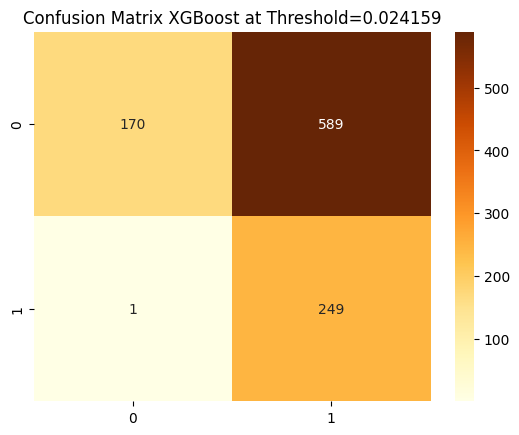

In [107]:
## Visualizing the improvement of our Linear Regression model to predict more True positives after changing the threshold to 0.291239
sns.heatmap(threshold_matrix, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix XGBoost at Threshold=0.024159")
plt.show()

Final Observartion
- Based on the various suitable thresholds chosen for XGBoost, Random Forest and Linear Regression models, XGBoost has the most True positives of about 249 and as a result, the False positive predictions are severely affected by this adjustment ie 170.
- Though Random Forest comes in second, having 242 True positives and 360 False positives, it hactually has a better balance between TPR and FPR.
- In addition, though Linear Regression comes in last having 234 True positives and 400 False positives, it also has a good balance between TPR and FPR.

Conclusion
- But for the sake of the objective of our project, we will choose XGBoost as the best model to predict the churn of customers.

##### Persiting the model (Saving the model)

In [121]:

## iterating through the model dictionary and saving the models
for model_name, Pipeline in all_balanced_pipeline.items():
    joblib.dump(Pipeline, f"../{model_name}.joblib")
    print(f"Model {model_name} saved to model folder")

Model Logistic Regression saved to model folder
Model Decision Tree saved to model folder
Model Random Forest saved to model folder
Model XGBoost saved to model folder


In [127]:
## Loading the models
XGBoost_model = joblib.load("../XGBoost.joblib")
XGBoost_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'Se...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])